In [2]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st

In [ ]:
# Data - BHRC
# Reporter - clinicians
# Hypothesis - 1 (depressed vs not depressed)

# Loading and prepping BHRC data

In [3]:
path_to_bhrcfile = '/data/MBDU/bhrc/data/Pine_129BHRC_2022_04_14.csv'
bhrcfile = pd.read_csv(path_to_bhrcfile, sep=',', header=0, low_memory=False)
bhrcfile.head()

,ident,redcap_event_name,age,agem,page1,page1m,page2,page2m,nage,nagem,...,np_cl_p_fl,np_cl_int_fl,np_cl_ext_fl,np_cl_ddep_fl,np_cl_danx_fl,np_cl_dsoma_fl,np_cl_dadhd_fl,np_cl_dodd_fl,np_cl_dconduct_fl,schoolach_fl
0,1,wave0_arm_1,7.033539,84.402464,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.324395
1,1,wave1_arm_1,10.800821,129.609856,10.932238,131.186858,10.932238,131.186858,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.071568
2,1,wave2_arm_1,15.635866,187.630390,15.808350,189.700205,15.808350,189.700205,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.224725
3,2,wave0_arm_1,7.058179,84.698152,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,wave1_arm_1,10.132786,121.593429,10.784394,129.412731,10.789870,129.478439,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015597


In [18]:
bhrcfile.age.value_counts().to_frame().reset_index().sort_values(by=['index']).head(100)

,index,age
3335,5.856263,1
2116,6.031485,1
3483,6.283368,1
2982,6.568104,1
2199,6.595483,1
...,...,...
3280,7.197810,1
495,7.206023,3
1914,7.214237,1
2145,7.222450,1


In [21]:
exactly_13=bhrcfile.query("age >= 13.0 & age <=13.01")
exactly_13

,ident,redcap_event_name,age,agem,page1,page1m,page2,page2m,nage,nagem,...,np_cl_p_fl,np_cl_int_fl,np_cl_ext_fl,np_cl_ddep_fl,np_cl_danx_fl,np_cl_dsoma_fl,np_cl_dadhd_fl,np_cl_dodd_fl,np_cl_dconduct_fl,schoolach_fl
2302,768,wave1_arm_1,13.002053,156.024641,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.445055
3498,1167,wave0_arm_1,13.007529,156.090349,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.653412
3670,1224,wave1_arm_1,13.007529,156.090349,13.667351,164.008214,13.667351,164.008214,14.004107,168.049281,...,-0.065257,-0.32415,1.638181,-0.350368,-0.926008,-0.745389,0.227128,0.736448,1.112974,-0.347096
5596,1866,wave1_arm_1,13.002053,156.024641,13.201916,158.422998,13.201916,158.422998,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.648067


In [109]:
print(bhrcfile.shape)

(7533, 2250)


https://aseba.org/wp-content/uploads/DSM-Oriented-Guide-for-the-ASEBA.pdf <br>
DSM5 - summarize items  items 5, 14, 18, 24, 35, 52, 54, 76, 77, 91, 100, 102 and 103 <br>

### Table 1-3 a Items Comprising DSM-5-Oriented Scales for Ages 6-18
--> 5. Enjoys little (dom_s08_cbclp_w0w2 - cl5 - Few things give pleasure)<br>
--> 14. Cries (dom_s08_cbclp_w0w2 - cl14 - Cries a lot)<br>
--> 18. Harms self (cl18 - Hurts him/herself on purpose or tried to kill him/herself)<br>
--> 24. Doesn’t eat well (cl24 - Is hard to eat)<br>
--> 35. Worthless (cl35 - Feels worthless or inferior)<br>
--> 52. Guilty (cl52 - Feels very guilty)<br>
--> 54. Tired (cl54 - Feels too tired for no reason)<br>
--> 60. Apathetic - leave it because it's not in CBCL<br>
--> 76. Sleeps less (cl76 - Sleep less than most children)<br>
--> 77. Sleeps more (cl77 - Sleep more than most children during the day and / or at night)<br>
--> 91. Talks/thinks suicide (cl91 - Say you're going to kill yourself)<br>
--> 100. Sleep problems (cl100 - Have sleep problems)<br>
--> 102. Lacks energy  (cl102 - Is poorly active, slow in movement, or lacking energy)<br>
--> 103. Sad (cl103 - Is unhappy, sad or depressed)<br>


In [110]:
relevant_depression_columns = ["cl5", "cl14", "cl18", "cl24", "cl35", "cl52", "cl54", "cl76", "cl77", "cl91", "cl100", "cl102", "cl103"]

In [111]:
# handling missing data
# Check if there are no "99"s

for column in relevant_depression_columns:
    print(bhrcfile[column].value_counts())

0.0     3686
1.0     1175
2.0      492
99.0      10
Name: cl5, dtype: int64
0.0    4241
1.0     774
2.0     349
Name: cl14, dtype: int64
0.0    5157
1.0     138
2.0      69
Name: cl18, dtype: int64
0.0     4310
1.0      696
2.0      357
99.0       1
Name: cl24, dtype: int64
0.0     4381
1.0      735
2.0      245
99.0       3
Name: cl35, dtype: int64
0.0     4835
1.0      417
2.0      108
99.0       4
Name: cl52, dtype: int64
0.0     3962
1.0      908
2.0      490
99.0       4
Name: cl54, dtype: int64
0.0     4643
1.0      452
2.0      268
99.0       1
Name: cl76, dtype: int64
0.0     3985
1.0      785
2.0      592
99.0       2
Name: cl77, dtype: int64
0.0     5077
1.0      199
2.0       84
99.0       3
Name: cl91, dtype: int64
0.0     4829
1.0      375
2.0      157
99.0       2
Name: cl100, dtype: int64
0.0     4671
1.0      532
2.0      155
99.0       5
Name: cl102, dtype: int64
0.0     4474
1.0      716
2.0      171
99.0       1
Name: cl103, dtype: int64


In [113]:
# Remove the rows with 99s

bhrcfile[relevant_depression_columns] == 99


,cl5,cl14,cl18,cl24,cl35,cl52,cl54,cl76,cl77,cl91,cl100,cl102,cl103
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7528,False,False,False,False,False,False,False,False,False,False,False,False,False
7529,False,False,False,False,False,False,False,False,False,False,False,False,False
7530,False,False,False,False,False,False,False,False,False,False,False,False,False
7531,False,False,False,False,False,False,False,False,False,False,False,False,False


In [161]:
# check which wave nans were in 
#print(bhrcfile.p1dawbaage.astype(float).value_counts())
#print(bhrcfile.redcap_event_name.value_counts())
checkdf = bhrcfile[(bhrcfile[relevant_depression_columns] == 99).any(axis=1)]
print(checkdf.redcap_event_name.value_counts())
#print(checkdf.p1dawbaage.value_counts())

Series([], Name: redcap_event_name, dtype: int64)
Series([], Name: p1dawbaage, dtype: int64)


In [156]:
checkdf['age_9to13'] = (checkdf.p1dawbaage.astype(float) >= 9.0) & (checkdf.p1dawbaage.astype(float) <= 13.0)
checkdf.age_9to13.value_counts()


False    27
Name: age_9to13, dtype: int64

In [157]:
bhrcfile['age_9to13'] = (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
bhrcfile.age_9to13.value_counts()


True    2083
Name: age_9to13, dtype: int64

In [138]:
bhrcfile = bhrcfile[~(bhrcfile[relevant_depression_columns] == 99).any(axis=1)]
bhrcfile.head()

,ident,redcap_event_name,age,agem,page1,page1m,page2,page2m,nage,nagem,...,depression_clinician,healthy_clinician,anxiety_clinician,ADHD_clinician,depYES_anxietyadhdNO_clinician,depNO_anxietyadhdYES_clinician,depression_clinician_9to13,healthy_clinician_9to13,depYES_anxietyadhdNO_clinician_9to13,depNO_anxietyadhdYES_clinician_9to13
0,1,1,10.800821,129.609856,10.932238,131.186858,10.932238,131.186858,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
1,2,1,10.132786,121.593429,10.784394,129.412731,10.789870,129.478439,NaN,NaN,...,False,False,True,False,False,True,False,False,False,True
2,3,1,11.394935,136.739220,12.090349,145.084189,12.090349,145.084189,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
3,4,0,10.409309,124.911704,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
4,5,1,10.809035,129.708419,11.438741,137.264887,11.438741,137.264887,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False


In [139]:
print(bhrcfile.shape)

(2083, 2152)


In [140]:
# checking

for column in relevant_depression_columns:
    print(bhrcfile[column].value_counts())
    print(bhrcfile.index[bhrcfile[column] == 99].tolist())

0.0    1522
1.0     398
2.0     163
Name: cl5, dtype: int64
[]
0.0    1585
1.0     327
2.0     171
Name: cl14, dtype: int64
[]
0.0    2012
1.0      45
2.0      26
Name: cl18, dtype: int64
[]
0.0    1619
1.0     303
2.0     161
Name: cl24, dtype: int64
[]
0.0    1704
1.0     278
2.0     101
Name: cl35, dtype: int64
[]
0.0    1865
1.0     175
2.0      43
Name: cl52, dtype: int64
[]
0.0    1593
1.0     329
2.0     161
Name: cl54, dtype: int64
[]
0.0    1841
1.0     151
2.0      91
Name: cl76, dtype: int64
[]
0.0    1683
1.0     250
2.0     150
Name: cl77, dtype: int64
[]
0.0    1956
1.0      85
2.0      42
Name: cl91, dtype: int64
[]
0.0    1903
1.0     127
2.0      53
Name: cl100, dtype: int64
[]
0.0    1868
1.0     172
2.0      43
Name: cl102, dtype: int64
[]
0.0    1740
1.0     283
2.0      60
Name: cl103, dtype: int64
[]


In [141]:
# relevant_depression_columns = ["cl5", "cl14", "cl18", "cl24", "cl35", "cl52", "cl54", "cl76", "cl77", "cl91", "cl100", "cl102", "cl103"]
bhrcfile['cbcl_dsm_depression'] = bhrcfile.cl5 + bhrcfile.cl14 + bhrcfile.cl18 + bhrcfile.cl24 + bhrcfile.cl35 + bhrcfile.cl52 + bhrcfile.cl54 + bhrcfile.cl76 + bhrcfile.cl77 + bhrcfile.cl91 + bhrcfile.cl100 + bhrcfile.cl102 + bhrcfile.cl103
bhrcfile['cbcl_dsm_depression'].value_counts()

0.0     705
1.0     354
2.0     270
3.0     180
4.0     145
6.0      98
5.0      91
7.0      50
8.0      46
9.0      35
10.0     31
12.0     18
11.0     15
13.0     14
15.0     10
14.0      9
16.0      5
20.0      3
18.0      2
21.0      1
17.0      1
Name: cbcl_dsm_depression, dtype: int64

In [142]:
# checking for NaNs
print('HEALTHY')
print(bhrcfile.dcany.value_counts())

print('\nDEPRESSION')
print(bhrcfile.dcmadep.value_counts())
print(bhrcfile.dcotdep.value_counts())

print('\nANXIETY')
print(bhrcfile.dcsepa.value_counts())
print(bhrcfile.dcspph.value_counts())
print(bhrcfile.dcsoph.value_counts())
print(bhrcfile.dcpanic.value_counts())
print(bhrcfile.dcagor.value_counts())
print(bhrcfile.dcgena.value_counts())
print(bhrcfile.dcotanx.value_counts())

print('\nADHD')
print(bhrcfile.dcanyhk.value_counts())

HEALTHY
0.0    1543
2.0     540
Name: dcany, dtype: int64

DEPRESSION
0.0    2011
2.0      72
Name: dcmadep, dtype: int64
0.0    2075
2.0       8
Name: dcotdep, dtype: int64

ANXIETY
0.0    1992
2.0      91
Name: dcsepa, dtype: int64
0.0    2011
2.0      72
Name: dcspph, dtype: int64
0.0    2050
2.0      33
Name: dcsoph, dtype: int64
0.0    2080
2.0       3
Name: dcpanic, dtype: int64
0.0    2082
2.0       1
Name: dcagor, dtype: int64
0.0    2046
2.0      37
Name: dcgena, dtype: int64
0.0    2055
2.0      28
Name: dcotanx, dtype: int64

ADHD
0.0    1875
2.0     208
Name: dcanyhk, dtype: int64


In [143]:
bhrcfile['depression_clinician'] = (bhrcfile.dcmadep == 2) | (bhrcfile.dcotdep == 2)
bhrcfile['healthy_clinician'] = (bhrcfile.dcany == 0)
bhrcfile['anxiety_clinician'] = (bhrcfile.dcsepa == 2) | \
                        (bhrcfile.dcspph == 2) | \
                        (bhrcfile.dcsoph == 2) | \
                        (bhrcfile.dcpanic == 2) |\
                        (bhrcfile.dcagor == 2) | \
                        (bhrcfile.dcgena == 2) | \
                        (bhrcfile.dcotanx == 2) 
bhrcfile['ADHD_clinician'] = (bhrcfile.dcanyhk == 2)
bhrcfile['depYES_anxietyadhdNO_clinician'] = (bhrcfile.depression_clinician == True) & ((bhrcfile.anxiety_clinician == False) & (bhrcfile.ADHD_clinician == False))
bhrcfile['depNO_anxietyadhdYES_clinician'] = (bhrcfile.depression_clinician == False) & ((bhrcfile.anxiety_clinician == True) | (bhrcfile.ADHD_clinician == True))

bhrcfile['depression_clinician_9to13'] = (bhrcfile.depression_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
bhrcfile['healthy_clinician_9to13'] = (bhrcfile.healthy_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
bhrcfile['depYES_anxietyadhdNO_clinician_9to13'] = (bhrcfile.depYES_anxietyadhdNO_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
bhrcfile['depNO_anxietyadhdYES_clinician_9to13'] = (bhrcfile.depNO_anxietyadhdYES_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)

example table:<br>
<br>
ident redcap_event_name        age        agem      page1      page1m  \
0      1       wave0_arm_1   7.033539   84.402464        NaN         NaN   
1      1       wave1_arm_1  10.800821  129.609856  10.932238  131.186858   
2      1       wave2_arm_1  15.635866  187.630390  15.808350  189.700205   
3      2       wave0_arm_1   7.058179   84.698152        NaN         NaN   
4      2       wave1_arm_1  10.132786  121.593429  10.784394  129.412731   
5      2       wave2_arm_1  15.430527  185.166324  15.504449  186.053388   
6      3       wave0_arm_1   8.361396  100.336756   8.591376  103.096509   
7      3       wave1_arm_1  11.394935  136.739220  12.090349  145.084189   
8      3       wave2_arm_1  16.301164  195.613963  16.550308  198.603696   
9      4       wave0_arm_1  10.409309  124.911704        NaN         NaN   

In [144]:
#removing all rows where p1dawbaage <9 or >13
bhrcfile = bhrcfile[bhrcfile.p1dawbaage >= 9]
bhrcfile = bhrcfile[bhrcfile.p1dawbaage <= 13]
print(bhrcfile.shape)
print(bhrcfile['p1dawbaage'].value_counts())

(2083, 2152)
10.475017    8
11.271732    7
10.839151    6
11.104723    6
11.761807    6
            ..
9.727584     1
9.508556     1
9.689254     1
12.114990    1
9.505818     1
Name: p1dawbaage, Length: 1069, dtype: int64


In [145]:
bhrcfile.head()

,ident,redcap_event_name,age,agem,page1,page1m,page2,page2m,nage,nagem,...,depression_clinician,healthy_clinician,anxiety_clinician,ADHD_clinician,depYES_anxietyadhdNO_clinician,depNO_anxietyadhdYES_clinician,depression_clinician_9to13,healthy_clinician_9to13,depYES_anxietyadhdNO_clinician_9to13,depNO_anxietyadhdYES_clinician_9to13
0,1,1,10.800821,129.609856,10.932238,131.186858,10.932238,131.186858,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
1,2,1,10.132786,121.593429,10.784394,129.412731,10.789870,129.478439,NaN,NaN,...,False,False,True,False,False,True,False,False,False,True
2,3,1,11.394935,136.739220,12.090349,145.084189,12.090349,145.084189,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
3,4,0,10.409309,124.911704,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
4,5,1,10.809035,129.708419,11.438741,137.264887,11.438741,137.264887,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False


In [146]:
bhrcfile.ident.value_counts()

1       1
1706    1
1703    1
1701    1
1700    1
       ..
853     1
850     1
849     1
848     1
2512    1
Name: ident, Length: 2083, dtype: int64

In [147]:
# sort by age and subject and then group by subject and use .first()

In [148]:
bhrcfile.redcap_event_name.value_counts()

0    1551
1     532
Name: redcap_event_name, dtype: int64

In [149]:
bhrcfile = bhrcfile.replace('wave0_arm_1', 0)
bhrcfile = bhrcfile.replace('wave1_arm_1', 1)
bhrcfile = bhrcfile.replace('wave2_arm_1', 2)
bhrcfile.redcap_event_name.value_counts()

0    1551
1     532
Name: redcap_event_name, dtype: int64

In [150]:
bhrcfile = bhrcfile.sort_values(['ident', 'p1dawbaage'])
bhrcfile = bhrcfile.groupby(by=['ident'])
bhrcfile[['ident', 'redcap_event_name', 'p1dawbaage']].head(10)

,ident,redcap_event_name,p1dawbaage
0,1,1,10.937714
1,2,1,10.800821
2,3,1,12.054757
3,4,0,10.475017
4,5,1,11.173169
...,...,...,...
2078,2507,1,12.350445
2079,2508,0,10.548939
2080,2509,0,9.505818
2081,2511,1,12.002738


In [151]:
bhrcfile.ident.value_counts()

ident  ident
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
               ..
2507   2507     1
2508   2508     1
2509   2509     1
2511   2511     1
2512   2512     1
Name: ident, Length: 2083, dtype: int64

In [152]:
bhrcfile = bhrcfile.first('1D')
bhrcfile[['redcap_event_name', 'p1dawbaage']].head()

,redcap_event_name,p1dawbaage
ident,,
1,1,10.937714
2,1,10.800821
3,1,12.054757
4,0,10.475017
5,1,11.173169


In [153]:
bhrcfile = bhrcfile.reset_index(level=0)
bhrcfile.ident.value_counts()

1       1
1706    1
1703    1
1701    1
1700    1
       ..
853     1
850     1
849     1
848     1
2512    1
Name: ident, Length: 2083, dtype: int64

In [154]:
# checking numbers of depressed etc
print("Depressed 9 to 13 - clinician")
print(bhrcfile['depression_clinician_9to13'].value_counts())
print("\nHealthy 9 to 13 - clinician")
print(bhrcfile['healthy_clinician_9to13'].value_counts())
print("\ndepYES_anxietyadhdNO_clinician - clinician")
print(bhrcfile['depYES_anxietyadhdNO_clinician_9to13'].value_counts())
print("\ndepNO_anxietyadhdYES_clinician - clinician")
print(bhrcfile['depNO_anxietyadhdYES_clinician_9to13'].value_counts())

Depressed 9 to 13 - clinician
False    2003
True       80
Name: depression_clinician_9to13, dtype: int64

Healthy 9 to 13 - clinician
True     1543
False     540
Name: healthy_clinician_9to13, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
False    2040
True       43
Name: depYES_anxietyadhdNO_clinician_9to13, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
False    1723
True      360
Name: depNO_anxietyadhdYES_clinician_9to13, dtype: int64


In [86]:
bhrcfile.shape

(2083, 2152)

In [87]:
mybhrcfile = bhrcfile[['ident', 'p1dawbaage', 'redcap_event_name', 'depression_clinician_9to13', 'healthy_clinician_9to13', 'depYES_anxietyadhdNO_clinician_9to13', 'depNO_anxietyadhdYES_clinician_9to13', 'cbcl_dsm_depression']]
print(mybhrcfile.shape)
print(mybhrcfile.head())

(2083, 8)
   ident  p1dawbaage  redcap_event_name  depression_clinician_9to13  \
0      1   10.937714                  1                       False   
1      2   10.800821                  1                       False   
2      3   12.054757                  1                       False   
3      4   10.475017                  0                       False   
4      5   11.173169                  1                       False   

   healthy_clinician_9to13  depYES_anxietyadhdNO_clinician_9to13  \
0                     True                                 False   
1                    False                                 False   
2                     True                                 False   
3                     True                                 False   
4                     True                                 False   

   depNO_anxietyadhdYES_clinician_9to13  cbcl_dsm_depression  
0                                 False                  0.0  
1                           

In [21]:
mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)
mybhrcfile.head(10)

/tmp/ipykernel_7219/2129885117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


,ident,p1dawbaage,redcap_event_name,depression_clinician_9to13,healthy_clinician_9to13,depYES_anxietyadhdNO_clinician_9to13,depNO_anxietyadhdYES_clinician_9to13,cbcl_dsm_depression,gs_depression
0,1,10.937714,1,False,True,False,False,0.0,0
1,2,10.800821,1,False,False,False,True,5.0,0
2,3,12.054757,1,False,True,False,False,1.0,0
3,4,10.475017,0,False,True,False,False,1.0,0
4,5,11.173169,1,False,True,False,False,1.0,0
5,6,10.795346,0,True,False,True,False,13.0,1
6,7,9.229295,0,False,True,False,False,0.0,0
7,9,12.394251,0,False,True,False,False,0.0,0
8,10,12.265572,1,False,True,False,False,3.0,0
9,11,10.154689,0,False,True,False,False,0.0,0


Now we create a dataset to work with, with desired length and positive-negative ratio
## Split into negative and positive gs diagnoses

In [22]:
is_gs_pos =  mybhrcfile['gs_depression']==1
pos_gs_all = mybhrcfile[is_gs_pos]
print(pos_gs_all.shape)

(80, 9)


In [23]:
pos_gs_all.head()

,ident,p1dawbaage,redcap_event_name,depression_clinician_9to13,healthy_clinician_9to13,depYES_anxietyadhdNO_clinician_9to13,depNO_anxietyadhdYES_clinician_9to13,cbcl_dsm_depression,gs_depression
5,6,10.795346,0,True,False,True,False,13.0,1
13,15,12.416153,0,True,False,True,False,4.0,1
82,96,11.816564,0,True,False,False,False,20.0,1
94,108,10.746064,0,True,False,True,False,11.0,1
127,145,11.236140,0,True,False,True,False,11.0,1


In [24]:
is_gs_neg =  mybhrcfile['healthy_clinician_9to13']==True
neg_gs_all = mybhrcfile[is_gs_neg]
print(neg_gs_all.shape)

(1543, 9)


## Randomly choose the neg_ksads subsample

In [25]:
num_pos = pos_gs_all.shape[0]
size_subsample = num_pos*10-num_pos # !
print(size_subsample)
neg_gs_subsample = neg_gs_all.sample(n = size_subsample)
print(neg_gs_subsample.head())
neg_gs_subsample.shape

720
      ident  p1dawbaage  redcap_event_name  depression_clinician_9to13  \
1714   2080    9.817933                  0                       False   
1198   1473   11.613963                  1                       False   
1071   1331    9.891855                  0                       False   
2052   2480    9.023956                  0                       False   
249     306   12.169747                  1                       False   

      healthy_clinician_9to13  depYES_anxietyadhdNO_clinician_9to13  \
1714                     True                                 False   
1198                     True                                 False   
1071                     True                                 False   
2052                     True                                 False   
249                      True                                 False   

      depNO_anxietyadhdYES_clinician_9to13  cbcl_dsm_depression  gs_depression  
1714                                 False 

(720, 9)

## Mix all positive cases and the subsample of negative cases. Then shuffle. 

In [26]:
frames = [pos_gs_all, neg_gs_subsample]
my_subsample = pd.concat(frames)
print(my_subsample.head())
print(my_subsample.shape)
my_subsample = my_subsample.sample(frac = 1)
print(my_subsample.head())
print(my_subsample.shape)

     ident  p1dawbaage  redcap_event_name  depression_clinician_9to13  \
5        6   10.795346                  0                        True   
13      15   12.416153                  0                        True   
82      96   11.816564                  0                        True   
94     108   10.746064                  0                        True   
127    145   11.236140                  0                        True   

     healthy_clinician_9to13  depYES_anxietyadhdNO_clinician_9to13  \
5                      False                                  True   
13                     False                                  True   
82                     False                                 False   
94                     False                                  True   
127                    False                                  True   

     depNO_anxietyadhdYES_clinician_9to13  cbcl_dsm_depression  gs_depression  
5                                   False                 13

In [27]:
my_subsample.isnull().sum()

ident                                   0
p1dawbaage                              0
redcap_event_name                       0
depression_clinician_9to13              0
healthy_clinician_9to13                 0
depYES_anxietyadhdNO_clinician_9to13    0
depNO_anxietyadhdYES_clinician_9to13    0
cbcl_dsm_depression                     0
gs_depression                           0
dtype: int64

# AUCROC
## Heavily using https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [28]:
y_true_df = my_subsample['gs_depression']
y_cbcl_df = my_subsample['cbcl_dsm_depression']

y_true = my_subsample['gs_depression'].tolist() # called y_test in the example
y_cbcl = my_subsample['cbcl_dsm_depression'].tolist() # called y_score in the example

In [29]:
sample_auc_score = roc_auc_score(y_true, y_cbcl)
sample_auc_score
# Note that we don't report this number in the paper. 
# Instead, we run bootstrapping, and report AUCROC from there (with confidence intervals)

0.9250520833333333

In [30]:
# plotting

In [32]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_true_df, y_cbcl_df)
roc_auc = auc(fpr, tpr)
roc_auc

0.9250520833333333

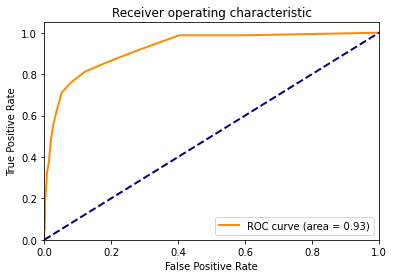

In [33]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# SAving

In [ ]:
# We save these data to later put all plots for each dataset in the same figure, for the paper

In [34]:
with open('../data_for_plotting/BHRC_data/BHRC_Hyp1_y_true_df.npy', 'wb') as f:
    np.save(f, y_true_df)
with open('../data_for_plotting/BHRC_data/BHRC_Hyp1_y_cbcl_df.npy', 'wb') as f:
    np.save(f, y_cbcl_df)

In [35]:
# Checking
with open('../data_for_plotting/BHRC_data/BHRC_Hyp1_y_true_df.npy', 'rb') as f:
    my_true_df = np.load(f)
with open('../data_for_plotting/BHRC_data/BHRC_Hyp1_y_cbcl_df.npy', 'rb') as f:
    my_cbcl_df = np.load(f)

In [36]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(my_true_df, my_cbcl_df)
roc_auc = auc(fpr, tpr)
roc_auc

0.9250520833333333

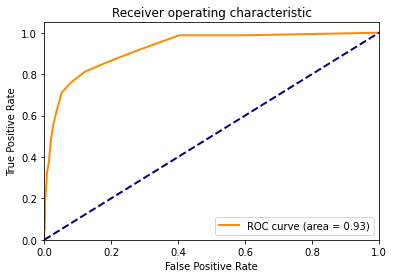

In [37]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Bootstrapping

In [38]:
rng = np.random.default_rng()
boot_ind = rng.choice(range(len(y_true_df)), size=y_true_df.size, replace=True)
boot_ind

array([ 26, 452, 378, 241, 347, 119, 723, 384, 777, 547, 460, 344, 222,
       217, 727, 284, 321, 208, 223, 449,  88, 558, 253, 480, 357, 768,
       600, 135, 104, 215, 238, 468, 536, 326, 589,  83, 448,  76, 699,
       211, 298, 180, 730, 671, 506, 287, 671, 659, 583, 488,  70, 342,
       610, 692, 206, 357, 419, 525, 740,  47, 665, 321, 634, 394, 447,
       741, 159, 216, 107, 125, 284, 795,  91, 388,  90, 111, 517, 619,
       655, 649, 710, 559, 655, 367, 267, 786, 491, 221, 415, 229, 297,
       778, 380, 736, 655,  46, 176, 132, 391, 684, 728,  40, 307, 587,
        21, 212, 539, 295, 485,  10, 132, 299, 353, 548, 264, 375, 100,
       510, 142, 532, 416, 154, 634, 157, 186, 517, 478,  13, 737, 527,
       590,   2, 238, 783, 494, 277, 122, 398, 520, 258, 497, 512,  49,
       206, 620, 424,  80, 231, 362, 586, 583, 607, 214, 264, 747,  74,
       768, 207, 387, 135,   1, 181, 665, 336, 760, 582, 709, 641, 277,
       784, 483, 148, 345, 115, 635, 540, 495, 421,  88, 665, 70

In [39]:
print(type(y_true_df))
y_true_df = y_true_df.to_frame()
y_cbcl_df = y_cbcl_df.to_frame()
print(type(y_true_df))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [40]:
y_true_df.head()

,gs_depression
642,0
254,0
1006,0
1278,0
853,0


In [41]:
boot_truth = y_true_df.iloc[boot_ind]
boot_score = y_cbcl_df.iloc[boot_ind]
print(y_cbcl_df.head(5))
print(boot_score.head(5))

      cbcl_dsm_depression
642                   0.0
254                   1.0
1006                  1.0
1278                  2.0
853                   0.0
      cbcl_dsm_depression
1860                  6.0
645                   0.0
2079                  0.0
647                   7.0
1582                  0.0


In [42]:
def gen_auc_boots(scores, truth, nboots=100, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    boot_res = []
    for pp in range(nboots):
        boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
        boot_truth = truth.iloc[boot_ind]
        boot_score = scores.iloc[boot_ind]
        boot_res.append(roc_auc_score(boot_truth, boot_score))
    return np.array(boot_res)

In [43]:
target_auc = 0.8 # because we defined it this way. Change for Hyp 2b.

boots = gen_auc_boots(y_cbcl_df, y_true_df, nboots=1000, rng=rng)
boots = np.hstack([boots, np.array([sample_auc_score])])
p = (boots >= target_auc).mean()

In [44]:
boots

array([0.9262002 , 0.93265794, 0.93754736, ..., 0.9354422 , 0.91354539,
       0.92505208])

In [45]:
min(boots)

0.8706574712643678

In [46]:
p

1.0

# RESULTS

In [47]:
p_onesided = (boots >= target_auc).mean()
p_onesided

1.0

In [48]:
p_twosided1 = (boots > target_auc).mean()
p_twosided2 = (boots < target_auc).mean()
p_twosided = min(p_twosided1, p_twosided2)*2
p_twosided

0.0

In [ ]:
print(np.quantile(boots, .025))
print(np.quantile(boots, .975))
boots_mean_AUCROC = np.mean(boots)
print(boots_mean_AUCROC, '(', np.quantile(boots, .025), np.quantile(boots, .975), ')')

# Confusion matrix

In [53]:
conf_fpr, conf_tpr, conf_thresh = roc_curve(y_true, y_cbcl)
conf_thresh

array([22., 21., 20., 18., 17., 16., 15., 14., 13., 12., 11., 10.,  9.,
        8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.])

In [54]:
roc_auc = auc(conf_fpr, conf_tpr)
roc_auc

0.9250520833333333

In [55]:
print(y_cbcl[:50])
print(min(y_cbcl))
print(max(y_cbcl))

[0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 4.0, 1.0, 15.0, 0.0, 2.0, 0.0, 4.0, 20.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 8.0, 4.0, 3.0, 6.0, 2.0, 6.0, 5.0, 1.0, 0.0, 5.0, 3.0, 9.0, 9.0, 1.0, 0.0, 5.0, 9.0, 1.0, 5.0, 21.0, 8.0, 0.0, 0.0, 4.0, 7.0, 0.0, 9.0]
0.0
21.0


In [56]:
def predict_y(cbcl, threshold):
    y_score = []
    for item in y_cbcl:
        if item >= threshold:
            y_score.append(1)
        else:
            y_score.append(0)
    return y_score

In [57]:
# Create a dataframe for all data for thresholds and associated fpr, tpr, tp, tn, fp, fn

# and also euclidian distance
# --> tpr - y axis 
# --> fpr - x axis 
# We want to calculate an Euclidian distance to (0,1) for each point on the ROC curve and pick the point where that is minimized. 

## dist = sqrt((x2 - x1)^2 + (y2 - y1)^2) 
## dist = sqrt(square(x2 - x1) + square(y2 - y1)) 

# I will create the df from a list of lists

# first initiate the lists

all_roc_auc = []
all_fpr = []
all_tpr = []
all_tn = []
all_fp = []
all_fn = []
all_tp = []
all_thresholds = []
all_euclidian = []

# Point to calculate the Euclidian distance with - (0, 1)
optimal_performance = np.array((0, 1))

# now iterate through thesholds, calculate the values of interest, update the lists

for threshold in range (0,50): #51,90
    # predict diagnoses with the given threshold
    y_score = predict_y(y_cbcl, threshold)
    # calculate fp, fn, tp, tn, aucroc
    tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    # calculate euclidian
    fpr_tpr_datapoint = np.array((fpr, tpr))
    sum_sq = np.sum(np.square(optimal_performance - fpr_tpr_datapoint))
    euclidian = np.sqrt(sum_sq)
    
    # update all lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_tn.append(tn)
    all_fp.append(fp)
    all_fn.append(fn)
    all_tp.append(tp)
    all_thresholds.append(threshold)
    all_euclidian.append(euclidian)


# make a dataframe out of lists

conf_matrices_data = pd.DataFrame(list(zip(all_thresholds, all_euclidian, all_fpr, all_tpr, all_tp, all_tn, all_fp, all_fn)),
               columns =['threshold', 'Euclidian', 'FPR', 'TPR', 'TP', 'TN', 'FP', 'FN'])

conf_matrices_data

,threshold,Euclidian,FPR,TPR,TP,TN,FP,FN
0,0,1.000000,1.000000,1.0000,80,0,720,0
1,1,0.591799,0.591667,0.9875,79,294,426,1
2,2,0.402972,0.402778,0.9875,79,430,290,1
3,3,0.288585,0.275000,0.9125,73,522,198,7
4,4,0.239284,0.195833,0.8625,69,579,141,11
5,5,0.223818,0.122222,0.8125,65,632,88,15
6,6,0.251239,0.081944,0.7625,61,661,59,19
7,7,0.292304,0.052778,0.7125,57,682,38,23
8,8,0.376870,0.037500,0.6250,50,693,27,30
9,9,0.450773,0.026389,0.5500,44,701,19,36


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


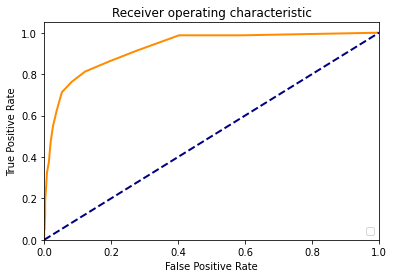

In [58]:
# Just to visualize

plt.figure()
lw = 2 # linewidt
plt.plot(
    all_fpr,
    all_tpr,
    color="darkorange",
    lw=lw,
    #label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [59]:
# Find the best fpr/tpr pair

# What is the min euclidian distance in the dataframe?
conf_matrices_data[['Euclidian']].idxmin()

Euclidian    5
dtype: int64

In [60]:
conf_matrices_data.loc[5]

threshold      5.000000
Euclidian      0.223818
FPR            0.122222
TPR            0.812500
TP            65.000000
TN           632.000000
FP            88.000000
FN            15.000000
Name: 5, dtype: float64